In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/Multi-Label Text Classification Dataset.csv


In [6]:
import sklearn.model_selection 
import sklearn.metrics
import os
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict
import torch
import torch.nn as nn

device = torch.device('cuda')

<h2> Importing Dataset </h2>

In [7]:
file_path = "/kaggle/input/dataset/Multi-Label Text Classification Dataset.csv"
df = pd.read_csv(file_path)

In [8]:
df.head()

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,E,F,G,H,I,J,L,M,N,Z
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",0,1,1,1,1,0,0,1,0,0,0,0,0,0
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",0,1,1,1,1,1,1,0,1,1,0,1,1,1
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",1,1,0,1,1,0,1,0,0,0,1,0,0,0
3,Multilayer capsules: a promising microencapsul...,"In 1980, Lim and Sun introduced a microcapsule...","['Acrylic Resins', 'Alginates', 'Animals', 'Bi...",11426874,"[['D05.750.716.822.111', 'D25.720.716.822.111'...","['Chemicals and Drugs [D]', 'Technology, Indus...",1,1,1,1,1,0,1,0,0,1,0,0,0,0
4,"Nanohydrogel with N,N'-bis(acryloyl)cystine cr...",Substantially improved hydrogel particles base...,"['Antineoplastic Agents', 'Cell Proliferation'...",28323099,"[['D27.505.954.248'], ['G04.161.750', 'G07.345...","['Chemicals and Drugs [D]', 'Phenomena and Pro...",1,1,0,1,1,0,1,0,0,1,0,0,0,0


<h3> Dropping Unnecessary Columns </h3>

In [9]:
df.drop(columns=['pmid'], inplace=True)
df.drop(columns=['meshid'], inplace=True)
df.drop(columns=['meshMajor'], inplace=True)
df.drop(columns=['meshroot'], inplace=True)

In [10]:
df.head()

,Title,abstractText,A,B,C,D,E,F,G,H,I,J,L,M,N,Z
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,0,1,1,1,1,0,0,1,0,0,0,0,0,0
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,0,1,1,1,1,1,1,0,1,1,0,1,1,1
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,1,1,0,1,1,0,1,0,0,0,1,0,0,0
3,Multilayer capsules: a promising microencapsul...,"In 1980, Lim and Sun introduced a microcapsule...",1,1,1,1,1,0,1,0,0,1,0,0,0,0
4,"Nanohydrogel with N,N'-bis(acryloyl)cystine cr...",Substantially improved hydrogel particles base...,1,1,0,1,1,0,1,0,0,1,0,0,0,0


<h3> Creating Single 'Text' Column </h3>

In [11]:
df['Text'] = df[df.columns[0]].astype(str) + ' ' + df[df.columns[1]].astype(str)
df.drop(columns=[df.columns[0], df.columns[1]], inplace=True)

In [12]:
df.head()

,A,B,C,D,E,F,G,H,I,J,L,M,N,Z,Text
0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,Expression of p53 and coexistence of HPV in pr...
1,0,1,1,1,1,1,1,0,1,1,0,1,1,1,Vitamin D status in pregnant Indian women acro...
2,1,1,0,1,1,0,1,0,0,0,1,0,0,0,[Identification of a functionally important di...
3,1,1,1,1,1,0,1,0,0,1,0,0,0,0,Multilayer capsules: a promising microencapsul...
4,1,1,0,1,1,0,1,0,0,1,0,0,0,0,"Nanohydrogel with N,N'-bis(acryloyl)cystine cr..."


<h3> Splitting Dataset </h3>

In [13]:
from sklearn.model_selection import train_test_split
train_data, remaining_data = train_test_split(df, test_size=0.25, random_state=42)
test_data, validation_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

In [14]:
print(f"Train: {train_data.shape}, Test: {test_data.shape}, Valid: {validation_data.shape}")

Train: (37500, 15), Test: (6250, 15), Valid: (6250, 15)


In [15]:
# Hyperparameters
MAX_LEN = 64
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid

<h2> Importing BERT </h2>

In [16]:
from transformers import BertTokenizer, BertModel

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

<h3> Class Custom Dataset </h3>

In [18]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['Text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len
        
    def __len__(self):
        return len(self.title)
    
    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [19]:
target_list = list(df.columns)
target_list = target_list[:-1]
target_list

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']

<h4>Train, Test, and Validation Dataset</h4>

In [21]:
train_dataset = CustomDataset(train_data, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(validation_data, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(test_data, tokenizer, MAX_LEN, target_list)

In [23]:
# Data Loader Instances

train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

<h3> Defining BERT Classifier </h3>

In [24]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 14)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

<h3>Loss Function</h3>

We are using a Binary Cross-Entropy Loss Function with Logits

logits: These are the raw output scores from the model. They can be any real numbers.
targets: These are the binary labels for each class. Each element is either 0 or 1.

BCEWithLogitsLoss function computes the binary cross-entropy loss with logits for each class independently.

Final Loss is the computed loss value which is a scalar representing the average loss over all samples and classes.

In [25]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [26]:
# AdamW: Adaptive Moment Estimation (Adam) with Weight Decay
# It decouples the weight decay from the gradient update step. This results in a more straightforward and effective application of L2 regularization.

from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)  

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<h2> Model Training </h2>

In [29]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), leave=True, colour='steelblue')
    
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [30]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

In [31]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '/kaggle/working/out.bin')
        best_accuracy = val_acc

Epoch 1/2


  0%|          | 0/1172 [00:00<?, ?it/s]

train_loss=0.3784, val_loss=0.3243 train_acc=0.8391, val_acc=0.8638
Epoch 2/2


  0%|          | 0/1172 [00:00<?, ?it/s]

train_loss=0.3079, val_loss=0.3011 train_acc=0.8720, val_acc=0.8737


<h3> Plotting Validation Accuracy v/s Epochs </h3>

In [34]:
import matplotlib.pyplot as plt

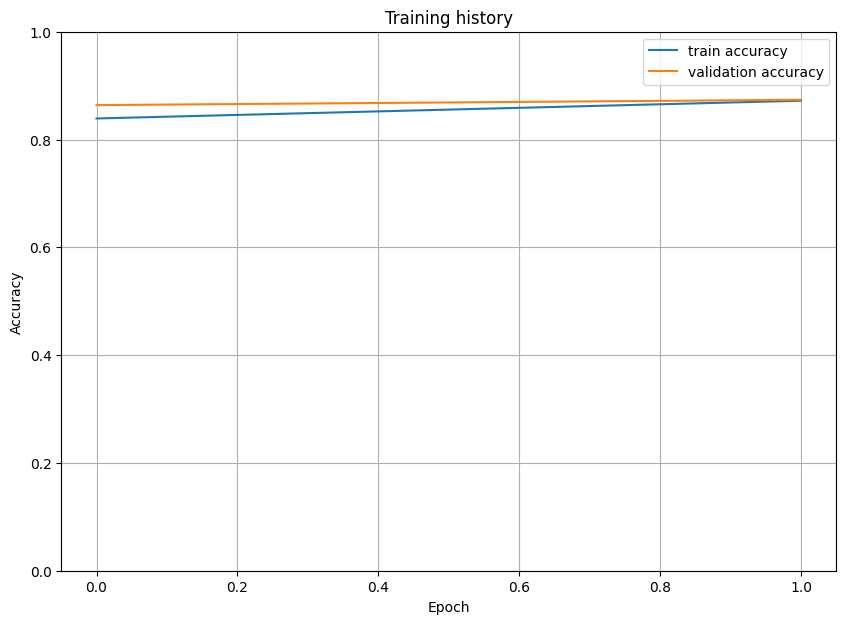

In [35]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

<h2> Model Evaluation </h2>

In [36]:
model = BERTClass()
model.load_state_dict(torch.load('/kaggle/working/out.bin'))
model = model.to(device)

In [37]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [38]:
test_acc

0.8745485714285715

In [39]:
from sklearn.metrics import classification_report

In [40]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
          for data in data_loader:
                title = data["title"]
                ids = data["input_ids"].to(device, dtype = torch.long)
                mask = data["attention_mask"].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data["targets"].to(device, dtype = torch.float)

                outputs = model(ids, mask, token_type_ids)
                # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
                outputs = torch.sigmoid(outputs).detach().cpu()
                # thresholding at 0.5
                preds = outputs.round()
                targets = targets.detach().cpu()

                titles.extend(title)
                predictions.extend(preds)
                prediction_probs.extend(outputs)
                target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return titles, predictions, prediction_probs, target_values

In [41]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

<h4> Classification Report </h4>

In [42]:
print(classification_report(target_values, predictions, target_names=target_list))

              precision    recall  f1-score   support

           A       0.82      0.78      0.80      2951
           B       0.96      0.98      0.97      5792
           C       0.89      0.86      0.87      3309
           D       0.90      0.93      0.91      3847
           E       0.80      0.97      0.88      4875
           F       0.88      0.64      0.74      1117
           G       0.81      0.90      0.85      4154
           H       0.66      0.05      0.10       800
           I       0.70      0.49      0.58       704
           J       0.74      0.36      0.49       696
           L       0.75      0.30      0.43       919
           M       0.85      0.89      0.87      2658
           N       0.82      0.75      0.78      2791
           Z       0.80      0.70      0.75      1004

   micro avg       0.85      0.83      0.84     35617
   macro avg       0.81      0.69      0.72     35617
weighted avg       0.85      0.83      0.83     35617
 samples avg       0.86   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
